### Evoluting a fruit-fly olfactory system in 2 minutes

In [0]:
import time
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import init
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

### Dataset
Here we define a dataset inspired by olfactory classification

In [0]:
# Dataset
n_train = 1000000  # number of training examples
n_val = 8192  # number of validation examples
n_class = 100  # number of classes
n_orn = 50  # number of olfactory receptor neurons

prototypes = np.random.uniform(0, 1, (n_class, n_orn)).astype(np.float32)
train_x = np.random.uniform(0, 1, (n_train, n_orn)).astype(np.float32)
val_x = np.random.uniform(0, 1, (n_val, n_orn)).astype(np.float32)

def get_labels(prototypes, odors):
    """Get label of nearest prototype for odors."""
    dist = euclidean_distances(prototypes, odors)
    return np.argmin(dist, axis=0)

train_y = get_labels(prototypes, train_x).astype(np.int32)
val_y = get_labels(prototypes, val_x).astype(np.int32)

### Model

Here we define a three layer feedforward network. The most critical architectural choice is to constraint the connection weights of the first two layers to be non-negative, similar to long-range excitatory connections.

In [0]:
def _get_normalization(norm_type, num_features=None):
    if norm_type is not None:
        if norm_type == 'batch_norm':
            return nn.BatchNorm1d(num_features)
    return lambda x: x


class Layer(nn.Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    Same as nn.Linear, except that weight matrix can be set non-negative
    """
    def __init__(self,
                 in_features,
                 out_features,
                 bias=True,
                 sign_constraint=False,
                 weight_initializer=None,
                 weight_initial_value=None,
                 bias_initial_value=0,
                 pre_norm=None,
                 post_norm=None,
                 dropout=False,
                 dropout_rate=None,
                 ):
        super(Layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        self.weight_initializer = weight_initializer
        if weight_initial_value:
            self.weight_init_range = weight_initial_value
        else:
            self.weight_init_range = 2. / in_features
        self.bias_initial_value = bias_initial_value
        self.sign_constraint = sign_constraint
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))

        self.pre_norm = _get_normalization(pre_norm, num_features=out_features)
        self.activation = nn.ReLU()
        self.post_norm = _get_normalization(post_norm, num_features=out_features)

        if dropout:
            self.dropout = nn.Dropout(p=dropout_rate)
        else:
            self.dropout = lambda x: x

        self.reset_parameters()

    def reset_parameters(self):
        if self.sign_constraint:
            self._reset_sign_constraint_parameters()
        else:
            self._reset_parameters()

    def _reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def _reset_sign_constraint_parameters(self):
        if self.weight_initializer == 'constant':
            init.constant_(self.weight, self.weight_init_range)
        elif self.weight_initializer == 'uniform':
            init.uniform_(self.weight, 0, self.weight_init_range)
        elif self.weight_initializer == 'normal':
            init.normal_(self.weight, 0, self.weight_init_range)
        else:
            raise ValueError('Unknown initializer', str(self.weight_initializer))

        if self.bias is not None:
            init.constant_(self.bias, self.bias_initial_value)

    @property
    def effective_weight(self):
        if self.sign_constraint:
            weight = torch.abs(self.weight)
        else:
            weight = self.weight

        return weight

    def forward(self, input):
        weight = self.effective_weight
        pre_act = F.linear(input, weight, self.bias)
        pre_act_normalized = self.pre_norm(pre_act)
        output = self.activation(pre_act_normalized)
        output_normalized = self.post_norm(output)
        output_normalized = self.dropout(output_normalized)
        return output_normalized


class FullModel(nn.Module):
    """"The full 3-layer model."""
    def __init__(self):
        super(FullModel, self).__init__()
        # ORN-PN
        self.layer1 = Layer(50, 50,
                            weight_initializer='normal',
                            sign_constraint=True,
                            pre_norm='batch_norm',
                            )

        # PN-KC
        self.layer2 = Layer(50, 2500,
                            weight_initializer='uniform',
                            weight_initial_value=0.2,
                            bias_initial_value=-1,
                            sign_constraint=True,
                            dropout=True,
                            dropout_rate=0.5)

        self.layer3 = nn.Linear(2500, 100)  # KC-output
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, target):
        act1 = self.layer1(x)
        act2 = self.layer2(act1)
        y = self.layer3(act2)
        loss = self.loss(y, target)
        with torch.no_grad():
            _, pred = torch.max(y, 1)
            acc = (pred == target).sum().item() / target.size(0)
        return {'loss': loss, 'acc': acc, 'kc': act2}

    @property
    def w_orn2pn(self):
        # Transpose to be consistent with tensorflow default
        return self.layer1.effective_weight.data.cpu().numpy().T

    @property
    def w_pn2kc(self):
        return self.layer2.effective_weight.data.cpu().numpy().T

### Training

Train the neural network on the dataset. Plot the connection weights during training.

[****************************************************]
Epoch 0
Train/Validation loss 0.00/6.34
Train/Validation accuracy nan/0.00


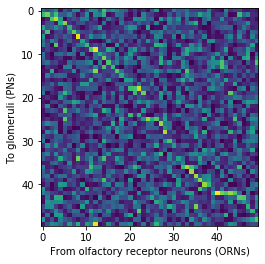

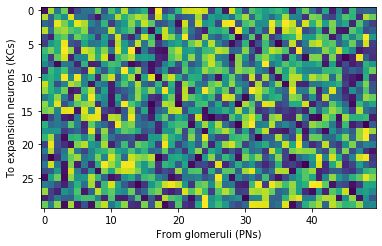

[****************************************************]
Epoch 1
Train/Validation loss 1.29/0.88
Train/Validation accuracy 0.52/0.73
Time taken 9.0s
Examples/second 111303
[****************************************************]
Epoch 2
Train/Validation loss 1.01/0.70
Train/Validation accuracy 0.70/0.76
Time taken 18.0s
Examples/second 110673
[****************************************************]
Epoch 3
Train/Validation loss 1.07/0.64
Train/Validation accuracy 0.64/0.78
Time taken 27.1s
Examples/second 110202


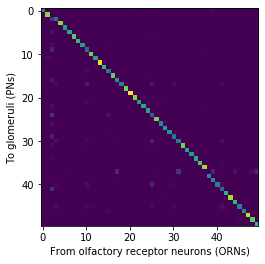

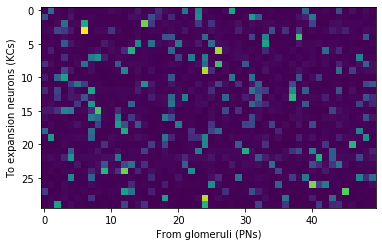

[****************************************************]
Epoch 4
Train/Validation loss 1.04/0.63
Train/Validation accuracy 0.64/0.78
Time taken 36.0s
Examples/second 111704
[****************************************************]
Epoch 5
Train/Validation loss 1.20/0.62
Train/Validation accuracy 0.59/0.79
Time taken 44.9s
Examples/second 112426
[****************************************************]
Epoch 6
Train/Validation loss 0.89/0.58
Train/Validation accuracy 0.73/0.81
Time taken 53.9s
Examples/second 111517


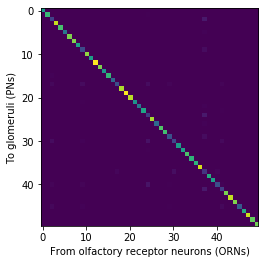

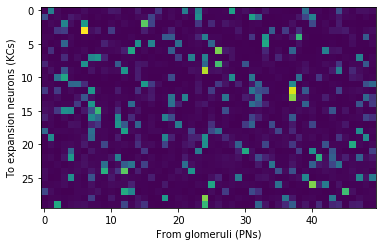

[****************************************************]
Epoch 7
Train/Validation loss 1.03/0.57
Train/Validation accuracy 0.64/0.80
Time taken 63.3s
Examples/second 106291
[****************************************************]
Epoch 8
Train/Validation loss 1.12/0.54
Train/Validation accuracy 0.66/0.82
Time taken 72.4s
Examples/second 110413
[****************************************************]
Epoch 9
Train/Validation loss 1.20/0.55
Train/Validation accuracy 0.67/0.80
Time taken 81.3s
Examples/second 111722


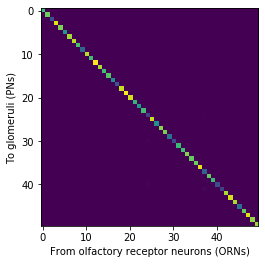

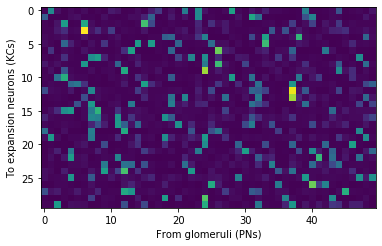

[****************************************************]
Epoch 10
Train/Validation loss 1.02/0.51
Train/Validation accuracy 0.72/0.83
Time taken 90.4s
Examples/second 109854
[****************************************************]
Epoch 11
Train/Validation loss 0.70/0.53
Train/Validation accuracy 0.73/0.82
Time taken 99.4s
Examples/second 111132
[****************************************************]
Epoch 12
Train/Validation loss 1.09/0.52
Train/Validation accuracy 0.64/0.82
Time taken 108.4s
Examples/second 111492


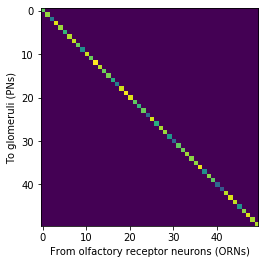

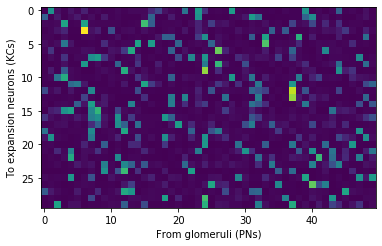

[****************************************************]
Epoch 13
Train/Validation loss 0.95/0.54
Train/Validation accuracy 0.64/0.81
Time taken 117.5s
Examples/second 110163
[****************************************************]
Epoch 14
Train/Validation loss 0.91/0.50
Train/Validation accuracy 0.72/0.83
Time taken 126.4s
Examples/second 111429


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256

model = FullModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def plot_weights():
    """Plot connection weights of the model"""
    w_orn2pn = model.w_orn2pn
    # print('The shape of weight ORN-PN:', w_orn2pn.shape)
    w_orn2pn = w_orn2pn[np.argsort(np.argmax(w_orn2pn, axis=1))]
    plt.figure()
    plt.imshow(w_orn2pn.T, aspect='equal')
    plt.xlabel('From olfactory receptor neurons (ORNs)')
    plt.ylabel('To glomeruli (PNs)')

    w_pn2kc = model.w_pn2kc
    # print('The shape of weight PN-KC:', w_pn2kc.shape)
    plt.figure()
    plt.imshow(w_pn2kc[:, :30].T, aspect='equal')
    plt.xlabel('From glomeruli (PNs)')
    plt.ylabel('To expansion neurons (KCs)')
    plt.show()

train_data = torch.from_numpy(train_x).float().to(device)
train_target = torch.from_numpy(train_y).long().to(device)
val_data = torch.from_numpy(val_x).float().to(device)
val_target = torch.from_numpy(val_y).long().to(device)

loss_train = 0
res = {'acc': np.nan}
total_time, start_time = 0, time.time()

for epoch in range(15):
    with torch.no_grad():
        model.eval()
        res_val = model(val_data, val_target)
    loss_val = res_val['loss'].item()

    print('[*' + '*'*50 + '*]')
    print('Epoch {:d}'.format(epoch))
    print('Train/Validation loss {:0.2f}/{:0.2f}'.format(
        loss_train, loss_val))
    print('Train/Validation accuracy {:0.2f}/{:0.2f}'.format(
        res['acc'], res_val['acc']))

    if epoch > 0:
        time_spent = time.time() - start_time
        total_time += time_spent
        print('Time taken {:0.1f}s'.format(total_time))
        print('Examples/second {:d}'.format(int(train_x.shape[0]/time_spent)))
    
    # Plot connection weights
    if epoch % 3 == 0:
        plot_weights()

    start_time = time.time()

    model.train()
    random_idx = np.random.permutation(n_train)
    idx = 0
    while idx < n_train:
        batch_indices = random_idx[idx:idx+batch_size]
        idx += batch_size

        res = model(train_data[batch_indices],
                    train_target[batch_indices])
        optimizer.zero_grad()
        res['loss'].backward()
        optimizer.step()

    loss_train = res['loss'].item()

### Quantify connectivity

Here we quantify the connectivity by first inferring a threshold between weak and strong connections. Then we quantify the number of strong connections received by each expansion layer neuron.

Text(0, 0.5, 'Number of KCs')

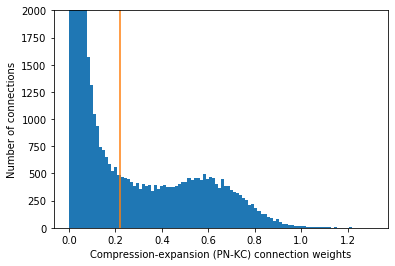

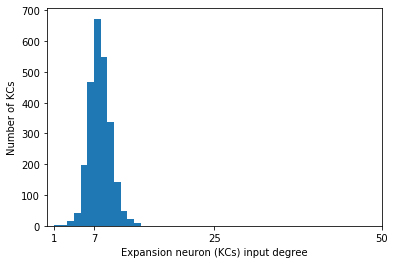

In [6]:
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

def infer_threshold(x):
    """Infers the threshold of a bi-modal distribution."""
    x = np.array(x).flatten()
    x = np.log(x +1e-10)

    clf = GaussianMixture(n_components=2, means_init=[[-5], [0.]], n_init=1)
    clf.fit(x[:, np.newaxis])

    x_tmp = np.linspace(x.min(), x.max(), 1000)
    pdf1 = multivariate_normal.pdf(x_tmp, clf.means_[0],
                                    clf.covariances_[0]) * clf.weights_[0]
    pdf2 = multivariate_normal.pdf(x_tmp, clf.means_[1],
                                    clf.covariances_[1]) * clf.weights_[1]
    if clf.means_[0, 0] < clf.means_[1, 0]:
        diff = pdf1 < pdf2
    else:
        diff = pdf1 > pdf2
    return np.exp(x_tmp[np.where(diff)[0][0]])

w_pn2kc = model.w_pn2kc
threshold = infer_threshold(w_pn2kc)

plt.figure()
plt.hist(w_pn2kc.flatten(), bins=100)
plt.ylim([0, 2000])
plt.plot([threshold, threshold], [0, 2000])
plt.xlabel('Compression-expansion (PN-KC) connection weights')
plt.ylabel('Number of connections')

plt.figure()
plt.hist(np.sum(w_pn2kc>threshold, axis=0), bins=np.arange(50))
plt.xlim([0, 50])
plt.xticks([1, 7, 25, 50])
plt.xlabel('Expansion neuron (KCs) input degree')
plt.ylabel('Number of KCs')